In [14]:
# !pip install -Uq --user nbdev
# !pip install huggingface_hub -U
!pip install -Uq --user 'timm==0.6.2.dev0'
try: import timm
except ModuleNotFoundError:
    !pip install -Uq 'timm==0.6.2.dev0'
try: import kaggle
except ModuleNotFoundError:
    !pip install -Uq --user 'kaggle'

from fastai.vision.all import *

In [15]:
timm.__version__

'0.6.2.dev0'

In [16]:
# easier to read
Path.BASE_PATh = path = Path('/notebooks/paddy/data')
train_images = path / 'train_images'
    

In [17]:
try: df = pd.read_csv(path/'train.csv')
except FileNotFoundError:
    !paddy/get_data.sh
    df = pd.read_csv(path/'train.csv')
    

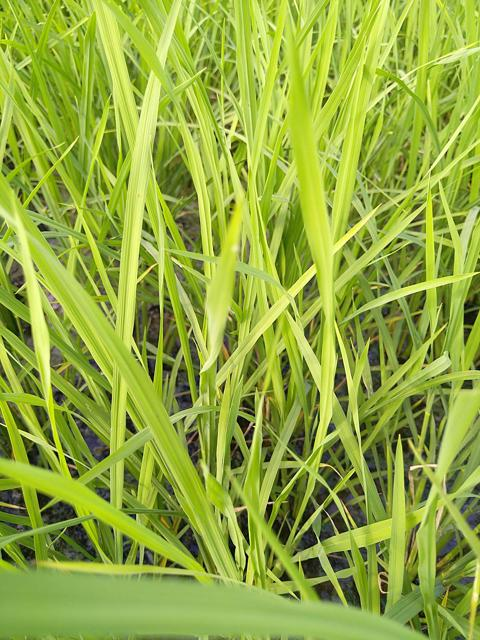

In [18]:
# view 1 image
fn, lb = df.sample(1).loc[:, ['image_id', 'label']].values.ravel()
img = PILImage.create(train_images/lb/fn)
img

In [19]:
img.size

(480, 640)

label is normal


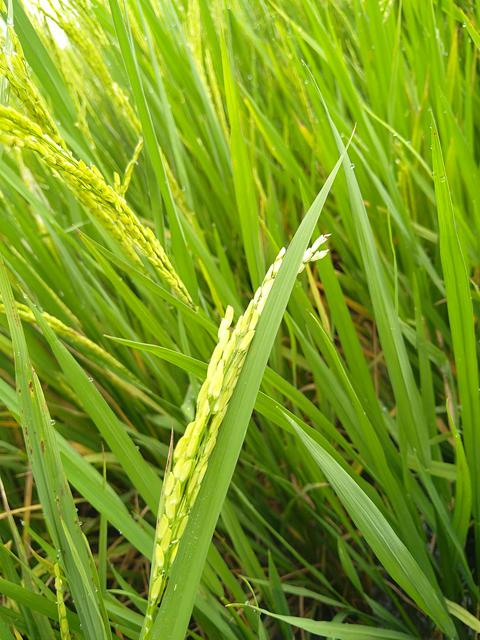

In [20]:
print("label is", lb)
files = get_image_files(train_images/lb)
img = PILImage.create(files[0])
img

In [21]:
# good chance to show case parallel
from fastcore.parallel import *

In [22]:
def f(o): return PILImage.create(o).size

In [23]:
sizes = parallel(f, files, n_workers=4)

In [24]:
# sizes
all( s == (480, 640) for s in sizes)

True

## Questions

- Will we need all images this big for decease detection?  or a resizing will be applied
- can we use the variety? multimodal vs single classification. For now ignore and try to classify decease. 

In [25]:
df['variety'].value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [26]:
# copied from intro fastbook
dls = ImageDataLoaders.from_folder(
     train_images, 
     valid_pct=.2, 
     item_tfms=Resize(224)
)

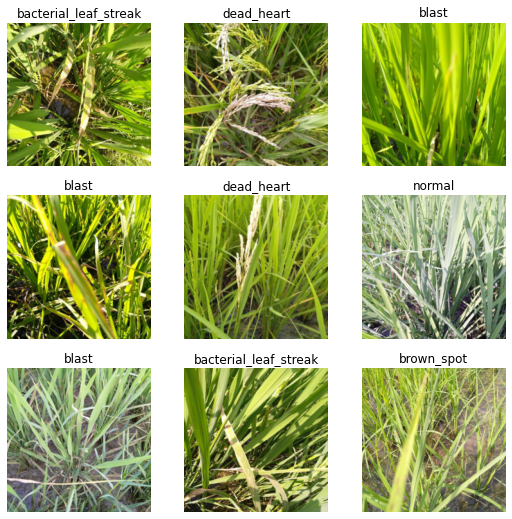

In [27]:
dls.show_batch()

In [28]:
# learn = vision_learner(dls, resnet34, metrics=error_rate)

In [29]:
# learn.fine_tune(1)

In [30]:
learn = vision_learner(dls, 'convnext_tiny', metrics=error_rate)

## Checking Fine Tune

1. Freeze -> only weigths of the last layer are changed (other are frooze)
2. fit one cycle -> only for the last layer we fit for the freeze epochs
3. half the learning rate 
4. unfreeze -> all layers can now be updated 
5. fit one cyle -> refit all weights for all weights 


In [31]:
# checking fine_tune on detail
learn.fine_tune??

Signature:
learn.fine_tune(
    epochs,
    base_lr=0.002,
    freeze_epochs=1,
    lr_mult=100,
    pct_start=0.3,
    div=5.0,
    *,
    lr_max=None,
    div_final=100000.0,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
File:      /usr/local/lib/python3.9/dist-packages/fastai/callback/schedule.py
Type:      method


## Checking Fit one cycle

- uses a scheduler (cosine): changes the lr during training
- when we have a randomly initiallised model, in the beginning we need to need to use a really small learning rate
- as it gets better and better you can increase the learning rate
- as you start to get close to the answer we need to decrease again; we are getting close
- there a great plot and link to papper in the doc for the method

In [32]:
doc(learn.fit_one_cycle)

In [33]:
learn.fit_one_cycle??

Signature:
learn.fit_one_cycle(
    n_epoch,
    lr_max=None,
    div=25.0,
    div_final=100000.0,
    pct_start=0.25,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
    start_epoch=0,
)
Source:   
@patch
def fit_one_cycle(self:Learner, n_epoch, lr_max=None, div=25., div_final=1e5, pct_start=0.25, wd=None,
                  moms=None, cbs=None, reset_opt=False, start_epoch=0):
    "Fit `self.model` for `n_epoch` using the 1cycle policy."
    if self.opt is None: self.create_opt()
    self.opt.set_hyper('lr', self.lr if lr_max is None else lr_max)
    lr_max = np.array([h['lr'] for h in self.opt.hypers])
    scheds = {'lr': combined_cos(pct_start, lr_max/div, lr_max, lr_max/div_final),
              'mom': combined_cos(pct_start, *(self.moms if moms is None else moms))}
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd, start_epoch=start_epoch)
File:      /usr/local/lib/python3.9/dist-packages/fastai/callback/schedule.py
Type:      meth

In [34]:
# learn.fine_tune(2) # look into fp_16 as a default run, run to proove results are in fact the same

In [35]:
# speeding up with fp16
learn = vision_learner(dls, 'convnext_tiny', metrics=error_rate).to_fp16()
learn.fine_tune(2)

## Get test data for inference

In [36]:
tst_files = get_image_files(path/'test_images')

In [37]:
tst_files.sort() # need sorting

In [38]:
tst_files

(#3469) [Path('/notebooks/paddy/data/test_images/200001.jpg'),Path('/notebooks/paddy/data/test_images/200002.jpg'),Path('/notebooks/paddy/data/test_images/200003.jpg'),Path('/notebooks/paddy/data/test_images/200004.jpg'),Path('/notebooks/paddy/data/test_images/200005.jpg'),Path('/notebooks/paddy/data/test_images/200006.jpg'),Path('/notebooks/paddy/data/test_images/200007.jpg'),Path('/notebooks/paddy/data/test_images/200008.jpg'),Path('/notebooks/paddy/data/test_images/200009.jpg'),Path('/notebooks/paddy/data/test_images/200010.jpg')...]

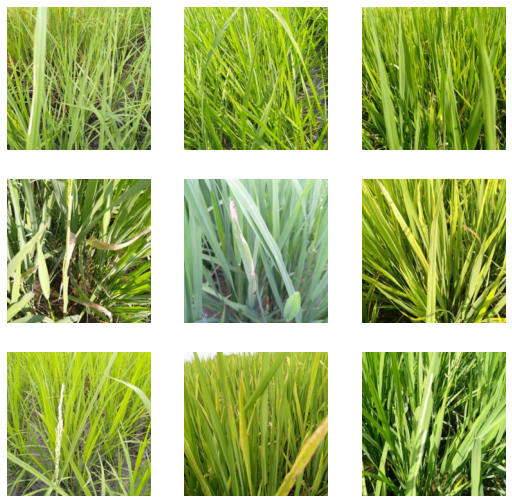

In [39]:
tst_dl = dls.test_dl(tst_files)
# notice no labesl on a 
tst_dl.show_batch()

In [40]:
# with indexes of highest prod
preds = learn.get_preds(dl=tst_dl, 
                        with_decoded=True)
# with_decoded will also return the decoded predictions using the decodes function of the loss function (if it exists). 
# For instance, fastai’s CrossEntropyFlat takes the argmax or predictions in its decodes.
prods,_, idxs = preds
idxs = pd.Series(idxs.numpy(), name='idxs')
mapper = pd.Series(dls.vocab)
results = idxs.map(mapper)
mapper

0       bacterial_leaf_blight
1       bacterial_leaf_streak
2    bacterial_panicle_blight
3                       blast
4                  brown_spot
5                  dead_heart
6                downy_mildew
7                       hispa
8                      normal
9                      tungro
dtype: object

In [41]:
doc(learn.get_preds)

In [42]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label']= results

In [43]:
ss.head()

image_id   label
0  200001.jpg   hispa
1  200002.jpg  normal
2  200003.jpg   blast
3  200004.jpg   blast
4  200005.jpg   blast

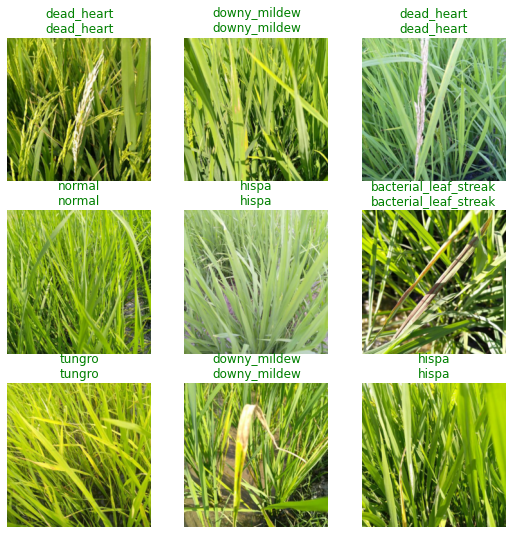

In [44]:
# check results submissions
learn.show_results()

In [45]:
# submitt
ss.to_csv('subm.csv', index=False)

## WT9 

improve model results

In [46]:
aug_transforms?

Signature:
aug_transforms(
    mult: 'float' = 1.0,
    do_flip: 'bool' = True,
    flip_vert: 'bool' = False,
    max_rotate: 'float' = 10.0,
    min_zoom: 'float' = 1.0,
    max_zoom: 'float' = 1.1,
    max_lighting: 'float' = 0.2,
    max_warp: 'float' = 0.2,
    p_affine: 'float' = 0.75,
    p_lighting: 'float' = 0.75,
    xtra_tfms: 'list' = None,
    size: 'int | tuple' = None,
    mode: 'str' = 'bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,
)
Docstring: Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.
File:      /usr/local/lib/python3.9/dist-packages/fastai/vision/augment.py
Type:      function


In [48]:
dls = ImageDataLoaders.from_folder(train_images, valid_pct=.2, 
                                   item_tfms=Resize(460, method='squish'),
                                   batch_tfms=aug_transforms(size=224, min_scale=.75))

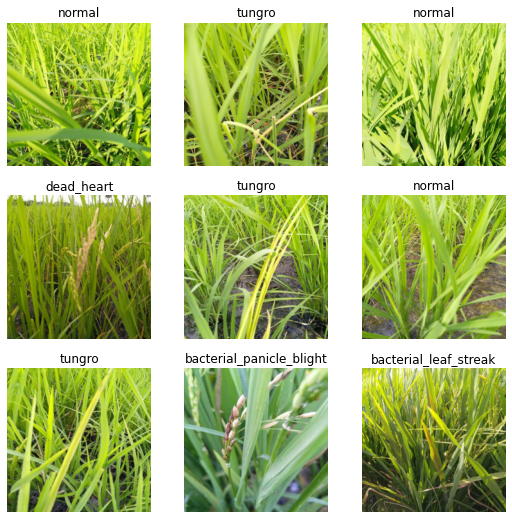

In [49]:
dls.show_batch()

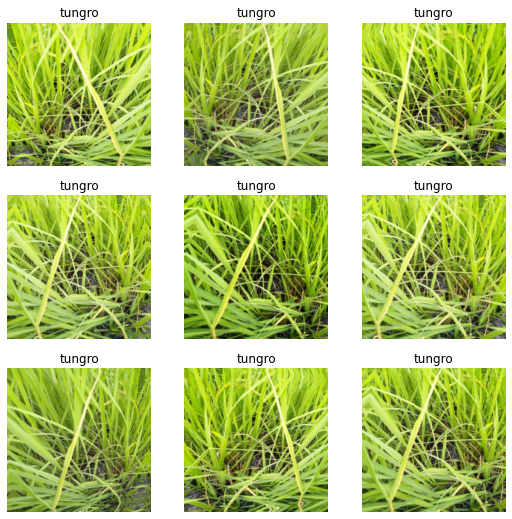

In [50]:
dls.show_batch(unique=True) #same images

In [51]:
aug_transforms(size=224, min_scale=.75)

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0, 'mode_mask': 'nearest', 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorMask,object) -> encodes
 decodes: ]

SuggestedLRs(valley=0.0010000000474974513)

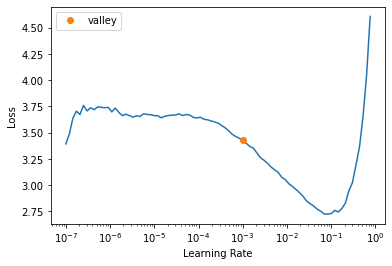

In [52]:
# speeding up with fp16
learn = vision_learner(dls, 'convnext_tiny', metrics=error_rate).to_fp16()
# get best lr , jeremy is less conservative than te lr find spot for valley
learn.lr_find()

In [53]:
learn.fine_tune(4, 0.01)

In [54]:
probs, targs = learn.get_preds(dl=dls.valid)

In [55]:
# quick test
error_rate(probs, targs) # matches last value of the ER

TensorBase(0.0514)

## TTA

In [56]:
doc(learn.tta)

In [57]:
learn.tta??

Signature:
learn.tta(
    ds_idx=1,
    dl=None,
    n=4,
    item_tfms=None,
    batch_tfms=None,
    beta=0.25,
    use_max=False,
)
Source:   
@patch
def tta(self:Learner, ds_idx=1, dl=None, n=4, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False):
    "Return predictions on the `ds_idx` dataset or `dl` using Test Time Augmentation"
    if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
    if item_tfms is not None or batch_tfms is not None: dl = dl.new(after_item=item_tfms, after_batch=batch_tfms)
    try:
        self(_before_epoch)
        with dl.dataset.set_split_idx(0), self.no_mbar():
            if hasattr(self,'progress'): self.progress.mbar = master_bar(list(range(n)))
            aug_preds = []
            for i in self.progress.mbar if hasattr(self,'progress') else range(n):
                self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
                aug_preds.append(self.get_preds(dl=dl, 

In [58]:
# using validation data
prob, targs = learn.tta(dl=dls.valid)
error_rate(prob, targs)

TensorBase(0.0457)

In [59]:
# no imp 
probs, targs = learn.tta(dl=dls.valid, use_max=True)
error_rate(probs, targs)

TensorBase(0.0447)

In [60]:
# using test data
tst_files = get_image_files(path/'test_images').sorted()

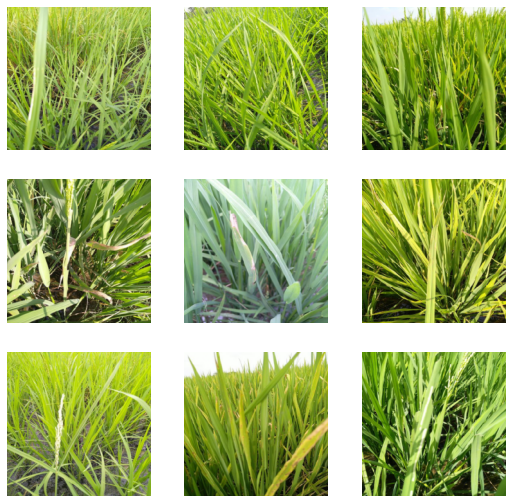

In [61]:
tst_dl = dls.test_dl(tst_files)
# notice no labesl on a 
tst_dl.show_batch()

In [ ]:
probs, targs = learn.tta(dl=tst_dl)

In [ ]:
idxs = probs.argmax(1)
idxs = pd.Series(idxs.numpy(), name='idxs')
mapper = pd.Series(dls.vocab)
results = idxs.map(mapper)

In [ ]:
results

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label']= results
ss.to_csv('subm2.csv', index=False)

In [ ]:
!head subm.csv

In [ ]:
!head subm2.csv